# Three-hinged arch, finding the worst loading case

This notebook aims to find the worst positionning of the snow load on an specific three-hinged arch.

We needed an angle on te very top of our arch, it is controlled by the global variable `k0 = 1.08875` but a perfect parabola will form with `k0=1.0`.

- Code:

  - The [Geometry](#Geometry-definition) section contains what defines the shape of the arch and the equivalent rectagular cross-section.

  - [Load functions](#Load-Functions) is where the external actions are defined. The intensities as well as the distributions are controlled from that part of the code. The dead load is dependent on the cross-section defined before.
  - [Solving](#System-solving-function) is where the statics comes in. An infinitely rigid system by computing a first-order solution. The `solve()` function begins by developping key variables such as the norm of the loads acting on each side (`F1` and `F2`) and their product with their respective centroids (`F1_c1` and `F2_c2`). A similar approach is used for horizontal forces. As the sytem is isostatic, the reactions are foud by solving the equilibrium equations with python's `numpy.linalg.solve` function. The moment diagram is then computed from those reactions. Most of its output leaks though `global` variables but it returns the maximal moment. This makes it a good objective function to maximize.
  - The results can be visualized thanks to the `diagram()` function in the [plotting](#Plotting-results,-finding-the-worst-case-with-a-widget) section.

  - [Finding the worst case scenario](#Finding-the-worst-case-scenario-with-numerical-optimization) makes use of the scipy library to maximize the greatest moment by positionning the snow load efectively.

- Plots:

  - Anything under the [Diagram for worst case scenario](#Diagram-for-worst-case-scenario) markdown will give more information concerning the final solution.

## Imports

In [1]:
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import animation as anim
import ipywidgets as widgets
from scipy.optimize import minimize,LinearConstraint
#from IPython.display import displayP = plt.rcParams

# Plotting preferences

In [2]:
from cycler import cycler
P = plt.rcParams
P["axes.spines.left"] = False
P["axes.spines.right"] = False
P["axes.spines.top"] = False
P["axes.spines.bottom"] = False
P["ytick.left"] = False
P["xtick.bottom"] = False
P["ytick.labelleft"] = False
P["xtick.labelbottom"] = False
P["font.size"]=20
P["figure.figsize"]=(12,10)
P['mathtext.fontset'] = 'cm'
jet = plt.cm.get_cmap('jet')

color_loads_ = "#DF4D55"
color_moment_= "lightseagreen"
color_arch = "k"
transparency_ = 0.1

color_loads = "#b51515"
color_moment= "#007e8a"
color_y  = "#f1c40f"
color_salmon="#ffdbe0"
transparency = 0.1 # for loads and moment diagram
P['axes.prop_cycle'] = cycler('color', [jet(1. * (9-i)/10) for i in range(10)])

moment_diag_scale = 0.05
loads_diag_scale  = 0.05

# Characteristic load values



In [3]:
l = 10000 # increase for more precise calculations
# Arch
L = 7.5
H = 5.0
k0 = 1.08875
element = "radial"
#element = "diagonal"
#element = None

if element == "radial":
    L = 7.5
elif element == "diagonal":
    L = 8.1936

### Section
thickness = 0.3 # m
width  = 0.4 # m
density = 23.5 # kN/m^3

max_concrete_width = 5.1 # m
light_concrete_density = 12 # kN/m^3
light_concrete_thickness = 0.3 # m

LC = {}

Lhinge = L/2

KFI = 1.1
# ext load
q1 = 0.8 # kN/m^2 snow
wind_pressure = 0.94 #
h_load = 1.0*0

### LC1 ###
q1 = 0.8*0 
wind_pressure = 1.0*0
density = 23.5*1.2
light_concrete_density = 12*1.2
### LC2 ###
q1 = 0.8*1.5 # kN/m^2 snow
wind_pressure = 1.0*0
density = 23.5
light_concrete_density = 12
### LC3 ###
q1 = 0.8*0.0 # kN/m^2 snow
wind_pressure = 1.0*1.5
density = 23.5
light_concrete_density = 12
###########

q1 = q1 *KFI
wind_pressure = wind_pressure *KFI
density = density *KFI
light_concrete_density = light_concrete_density *KFI


# Geometry functions

In [4]:
parabola   = lambda x, k=k0 : x*(k*L-x)*4/(L*(2*k*L-L))*H
para_deriv = lambda x, k=k0 : (k*L-2*x)*4/(L*(2*k*L-L))*H

def arches(x_input,k=k0):
    x = x_input.copy()
    x[x>Lhinge] = L-x[x>Lhinge]
    return parabola(x)

def tangent(x_input,k=k0): # normed tangents, only the direction is unchanged
    x = x_input[x_input<=Lhinge]
    x_= x_input[x_input>Lhinge]
    d = para_deriv(x)
    d = np.concatenate((d,-d[::-1][:min(len(x_),len(x))]))
    dv = np.array([np.ones_like(d),d])
    dv = dv/np.sqrt(d**2+1)
    return dv

def tangent_vec(x_input,k=k0): # tangent vector
    x = x_input[x_input<=Lhinge]
    x_= x_input[x_input>Lhinge]
    d = para_deriv(x)
    d = np.concatenate((d,-d[::-1][:min(len(x_),len(x))]))
    dv = np.array([np.ones_like(d),d])
    return dv

def normal_vector(x,d):
    vectors = np.zeros_like(d)
    vectors[0] =  d[1]
    vectors[1] = -d[0]
    
    return vectors

# Load Functions

In [5]:
def vert_load(x,xmin=0,xmax=L):

    load = np.zeros_like(x)
    load[(x>=xmin) & (x<=xmax)] = q1
    
    wth = np.linspace(0,max_concrete_width,l) # m
    
    load = load*wth
    
    return load

def light_concrete_load(d):

    thk = light_concrete_thickness # m
    wth = np.zeros(l)+max_concrete_width # m
    if element == "diagonal":
        wth = np.pi/8*(5.5 + np.linspace(0,L,l)) # m
    if element == "radial":
        wth = np.linspace(0,max_concrete_width,l) # m
    dns = light_concrete_density
    
    return dead_load(d,dns,thk,wth)
    
    
def dead_load(d,density,thickness,width):
    
    deriv_norm = np.sqrt(d**2+1)
    
    load = deriv_norm*density*thickness*width
    
    return load


def horizontal_load(x,n,hl):
    
    q_of_x = np.zeros_like(x) + hl
    q_of_x[x>Lhinge]  = 0
    
    return q_of_x

def surface_load(x,n,wp):

    wth = np.linspace(0,max_concrete_width,l) # m
    
    qx = np.zeros_like(n[0])+wp
    qy = np.zeros_like(n[1])+wp

    qy[x<=L/4] = -0.8*qy[x<=L/4]
    qx[x<=L/4] = -0.8*qx[x<=L/4]

    qy[x>L/4] = +1.2*qy[x>L/4]
    qx[x>L/4] = +1.2*qx[x>L/4]
    
    qy[x>3*L/4] = +0.4*qy[x>3*L/4]
    qx[x>3*L/4] = +0.4*qx[x>3*L/4]
    
    qx = qx*wth
    qy = qy*wth

    # Don't change this if you wish to keep the pressure convention
    qy[x>Lhinge] = -qy[x>Lhinge]
    # pressure +
    # depressure -
    return [qx, qy]


def total_load(x,d,xmin=0,xmax=L, hp = 0, n = np.zeros((l,2)), wp = 0):
    
    sf  = surface_load(x,n,wp)
    
    load  = vert_load(x,xmin,xmax)
    load += dead_load(d,density,thickness,width)
    load += light_concrete_load(d)
    load += sf[1]
    
    h  = sf[0]
    h += horizontal_load(x,n,hp)
    
    return [load,h]
### End load functions ###

# System solving function

In [6]:
### Simple integration function 
def integrate(x,y, r0=0):
    # basic integration function
    l = len(x)
    I = np.zeros_like(x)
    I[0] = r0
    
    for i in range(1,l):
        dx = x[i]-x[i-1]
        y_ = (y[i]+y[i-1])/2
        I[i] = I[i-1] + dx*y_
    
    return I


def solve(xs=[0,L]):
    
    xmin = xs[0]
    xmax = xs[1]

    if xmin>xmax-0.1:
        xmin = xmax-0.1

    global x, y, derivative, load, load_h
    global Ax, Ay, Bx, By, Cx, Cy
    global Rn, moment

    x = np.linspace(0,L,l)
    y = arches(x)
    dv = tangent(x)
    derivative = tangent_vec(x)[1]
    n = normal_vector(x,dv)
    
    tt_load = total_load(x,derivative,xmin,xmax,h_load,n,wind_pressure)
    load   = tt_load[0]
    #load = 0*load
    load_h = tt_load[1]
    #load_h = 0*load_h
    
    F  = np.trapz(load  ,x)
    Fx = np.trapz(load_h,y)


    ### Defining loads
    # Left arch
    x1 = x[x<=Lhinge]
    d1 = derivative[x<=Lhinge]
    y1 = y[x<=Lhinge]
    
    p1  =    load[x<=Lhinge]
    px1 =  load_h[x<=Lhinge]
    
    F1      = np.trapz(p1,    x=x1)
    F1x     = np.trapz(px1,   x=y1)
    F1_c1   = np.trapz(p1*x1, x=x1)
    F1x_c1y = np.trapz(px1*y1,x=y1)

    
    # Right arch
    x2 = x[x>Lhinge]
    d2 = derivative[x>Lhinge]
    y2 = y[x>Lhinge]
    
    p2  =    load[x>Lhinge]
    px2 =  load_h[x>Lhinge]
    
    F2      = np.trapz(p2,    x=x2)
    F2x     = np.trapz(px2*y2,x=y2)
    F2_c2   = np.trapz(p2*x2, x=x2)
    F2x_c2y = np.trapz(px2*y2,x=y2)

    

    ### Solving equilibrium
    ### For reactions
    A = np.array([
        [-1, 0, 1,      0, 0, 0],
        [-1, 0, 0,      0, 1, 0],
        [ 0, 1, 0,      1, 0, 0],
        [ 0, 1, 0,      0, 0, 1],
        [ 0, 0, H, Lhinge, 0, 0],
        [ 0, 0, H,-Lhinge, 0, 0],
    ])

    b = np.array([
        F1x,
        Fx,
        F1,
        F,
        F1_c1+F1x_c1y,
        F2*L-F2_c2 - F2x_c2y
    ])

    solution = np.linalg.solve(A,b)
    Ax, Ay, Bx, By, Cx, Cy = solution
    

    ### Calculating momment and normal force from rections
    # Left side
    F1s       = integrate(x1,p1)
    F1xs      = integrate(y1,px1)
    F1s_c1s   = integrate(x1,p1*x1)
    F1xs_c1ys = integrate(y1,px1*y1)
    dv1       = dv.T[x<=Lhinge].T

    R_vect = np.array([+Ax+F1xs,-F1s+Ay])
    R1  = -(R_vect[0]*dv1[0]+R_vect[1]*dv1[1])
    M1  = (F1s_c1s - x1*F1s) - Ax*y1       + Ay*x1    - (F1xs*y1-F1xs_c1ys)

    #right side

    F2s       = integrate(x2,p2)
    F2xs      = integrate(y2,px2)
    F2s_c2s   = integrate(x2,p2*x2)
    F2xs_c2ys = integrate(y2,px2*(H-y2))
    dv2       = dv.T[x>Lhinge].T

    R_vect = np.array([Bx+F2xs,-By-F2s])
    R2  = -(R_vect[0]*dv2[0]+R_vect[1]*dv2[1])
    M2  = (F2s_c2s - F2s*x2) - By*(x2-Lhinge) + Bx*(H-y2) + (F2xs*(H-y2) - F2xs_c2ys)

    Rn = np.concatenate((R1,R2))
    moment = np.concatenate((M1,M2))
    x = np.concatenate((x1,x2))
    y = arches(x)
    
    if xmin>=xmax-0.1:
        print(f"xminl too close or superior to xmax")
        print("xminl <- xmaxl-0.1")
        print()
    
    global argmaxmom, maxmoment, maxRn, MaxRn
    
    i = np.argmax(np.abs(moment))
    maxmoment = moment[i]
    maxRn  = Rn[i]
    MaxRn = np.min(Rn)
    
    return np.max(np.abs(moment))

# Plotting results, finding the worst case with a widget

In [7]:
def diagram(xminl=0,xmaxl=L,display_diagram=True):

    solve([xminl,xmaxl])
    
    print(f"Extreme moments          : {np.max(moment), np.min(moment)}")
    print(f"Extreme moments position : {x[np.argmax(moment)], x[np.argmin(moment)]}")
    print(f"M_max = {max(np.abs(moment))}")
    
    if display_diagram:
        
        if (load!=0).any():
            x_load = x[load!=0]
            p_load = load[load!=0]
            xmin = x_load[0]
            xmax = x_load[-1]
        else:
            x_load = x.copy()
            p_load = load.copy()
            xmin = 0
            xmax = L
            
        y_load_h = x[load_h!=0]
        p_load_h = load_h[load_h!=0]
        y_load_h = y.copy()
        p_load_h = load_h.copy()
            

        k = 1/loads_diag_scale
        h = H+0.5+abs(min(load))/k
        hh = -0.5 - abs(max(load_h))/k

        n = normal_vector(x,tangent(x))

        scale = moment_diag_scale
        
        mx = x + n[0]*moment*scale
        my = y + n[1]*moment*scale
        
        fig, ax = plt.subplots()
        ax.clear()
        ax.plot(x,y,color_arch,linewidth=2,label="Arches")
        ax.scatter([0,Lhinge,L],[0,H,0],facecolors="w",color=color_arch,s=100,zorder=3,label="Hinges")
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.2,edgecolor="white")
        ax.text(0+0.5,0,  r"$A_x=$"+f"{round(Ax,1)} kN \n"+r"$A_y=$"+f"{round(Ay,1)} kN ",bbox=props)
        ax.text(Lhinge+0.5,H-0.05,r"$B_x=$"+f"{round(Bx,1)} kN \n"+r"$B_y=$"+f"{round(By,1)} kN ")#,bbox=props)
        ax.text(L-3.0,0,  r"$C_x=$"+f"{round(Cx,1)} kN \n"+r"$C_y=$"+f"{round(Cy,1)} kN ",bbox=props)
        
        if not (p_load_h[x<=Lhinge]==0).all():
            left_side_array = x<=Lhinge
            p_load_h1 = p_load_h[left_side_array]
            y_load_h1 = y_load_h[left_side_array]
            ax.plot(hh-p_load_h1/k, y_load_h1, color_loads,label="loads")
            #ax.fill_between(hh-np.zeros_like(y_load_h1),y_load_h1,y_load_h1/k,color=color_loads,alpha=0.1)
            i = 999
            ax.plot(np.array([hh-np.zeros_like(p_load_h1)[::i],
                              hh-p_load_h1[::i]/k]),
                    np.array([y_load_h1[::i],y_load_h1[::i]]),
                                color=color_loads)
            ax.fill_betweenx(y_load_h1,hh-np.zeros_like(p_load_h1), hh-p_load_h1/k,interpolate=True,color=color_loads,alpha=transparency)

        if not (p_load_h[x>Lhinge]==0).all():
            right_side_array = x>Lhinge
            p_load_h2 = p_load_h[right_side_array]
            y_load_h2 = y_load_h[right_side_array]
            ax.plot(L - hh+p_load_h2/k, y_load_h2, color_loads)
            #plt.fill_between(hh-np.zeros_like(y_load_h1),y_load_h1,y_load_h1/k,color=color_loads,alpha=0.1)
            i = 999
            ax.plot(np.array([L-hh+np.zeros_like(p_load_h2)[::i],
                              L-hh+p_load_h2[::i]/k]),
                    np.array([y_load_h2[::i],y_load_h2[::i]]),
                                color=color_loads)
            ax.fill_betweenx(y_load_h2,L-hh+np.zeros_like(p_load_h2), L-hh+p_load_h2/k,interpolate=True,color=color_loads,alpha=transparency)
        
        
        if not (p_load==0).all():
            ax.plot(x_load,h + p_load/k,color_loads)
            ax.fill_between(x_load,h+np.zeros_like(x_load),h+p_load/k,color=color_loads,alpha=transparency)
            i = 999
            ax.plot(np.array([x_load[::i],x_load[::i]]),
                    np.array([h+np.zeros_like(p_load)[::i],
                              h+p_load[::i]/k]),
                                color=color_loads)

        ax.plot(mx,my,"-.",color=color_moment,label="Moment",linewidth=2)
        for i in range(len(moment))[::10]:
            ax.plot([x[i],mx[i]],[y[i],my[i]],color_moment,alpha=0.02,linewidth=6)
        
        #plt.xlabel("x [m]")
        #plt.ylabel("z [m]")
        plt.title("Moment diagram    " + r"$M_{max} = $"+f"{round(maxmoment,1)} kN.m")
        plt.legend(loc="upper left")
        fig.patch.set_facecolor('blue')
        fig.patch.set_alpha(0.0)
        ax.patch.set_facecolor('w')
        ax.patch.set_alpha(1.0)
        plt.savefig("Moment diagram.png",bbox_inches="tight",transparent=True,dpi=500)
        plt.show()

# Result

Extreme moments          : (40.6502253930647, -7.4690796884474855)
Extreme moments position : (6.152115211521152, 1.2518751875187517)
M_max = 40.6502253930647


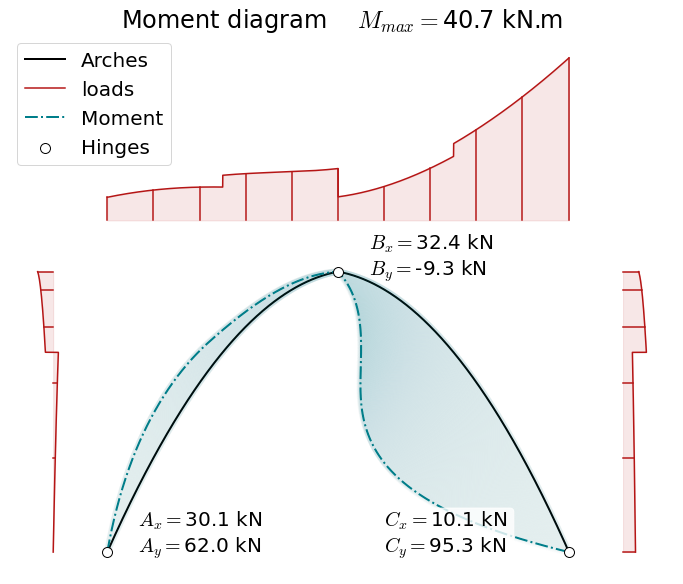

In [8]:
diagram()

In [9]:
#widg = widgets.interact(diagram,xminl=(0,L,0.1),xmaxl=(0,L,0.1));

# Finding the worst case scenario with numerical optimization

In [10]:
A = np.array([
    [1, 0],
    [0, 1],
    [-1,1]
])
lb = [0,0,0.11]
ub = [L,L,L]
cntrs = LinearConstraint(A, lb, ub)
x0 = [0,L]
solution = minimize(lambda x: -solve(x),x0,constraints = cntrs)

n_opt = 5
x01s = np.linspace(4.5,L-0.11,n_opt)

f = widgets.IntProgress(min=0, max=n_opt**2) # instantiate the bar
display(f) # display the bar

for x01 in x01s:
    x02s = np.linspace(x01+0.11,L,n_opt)
    for x02 in x02s:
        x0 = [x01,x02]
        solution_ = minimize(lambda x: -solve(x),x0,constraints = cntrs)
        if solution_.fun < solution.fun:
            solution = solution_
        f.value += 1
        f.description = str(solution.fun)
solution

IntProgress(value=0, max=25)

     fun: -40.6502253930647
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0. , 7.5])

# Diagram for worst case scenario

Extreme moments          : (40.6502253930647, -7.4690796884474855)
Extreme moments position : (6.152115211521152, 1.2518751875187517)
M_max = 40.6502253930647


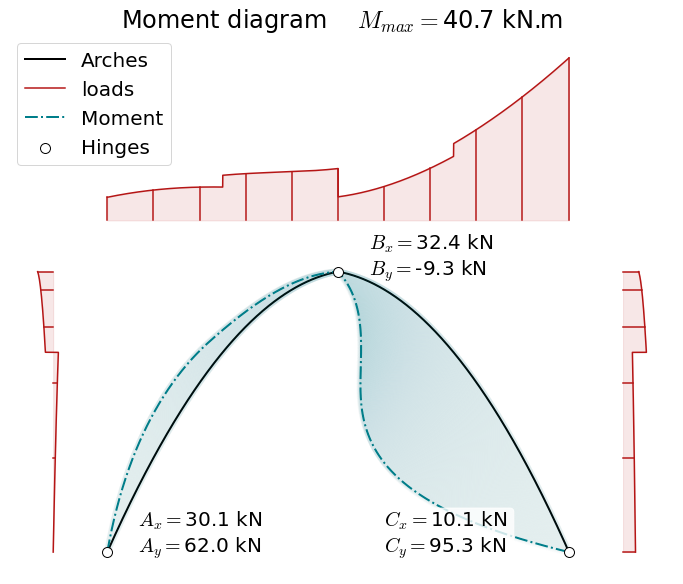

In [11]:
diagram(solution.x[0],solution.x[1])

In [12]:
maxmoment, maxRn, MaxRn

(40.6502253930647, -39.30790173461464, -92.11376338968486)

# Other values

In [13]:
display((Ax,Ay))

(30.083642440514865, 62.01866312852949)

In [14]:
display((Bx,By))

(32.38533713048498, -9.332695881853402)

In [15]:
display((Cx,Cy))

(10.093318194967008, 95.31776226883403)

# Moment and normal force plots

In [16]:
P["axes.spines.left"] = True
P["axes.spines.right"] = True
P["axes.spines.top"] = True
P["axes.spines.bottom"] = True
P["ytick.left"] = True
P["xtick.bottom"] = True
P["ytick.labelleft"] = True
P["xtick.labelbottom"] = True

<Figure size 864x720 with 0 Axes>

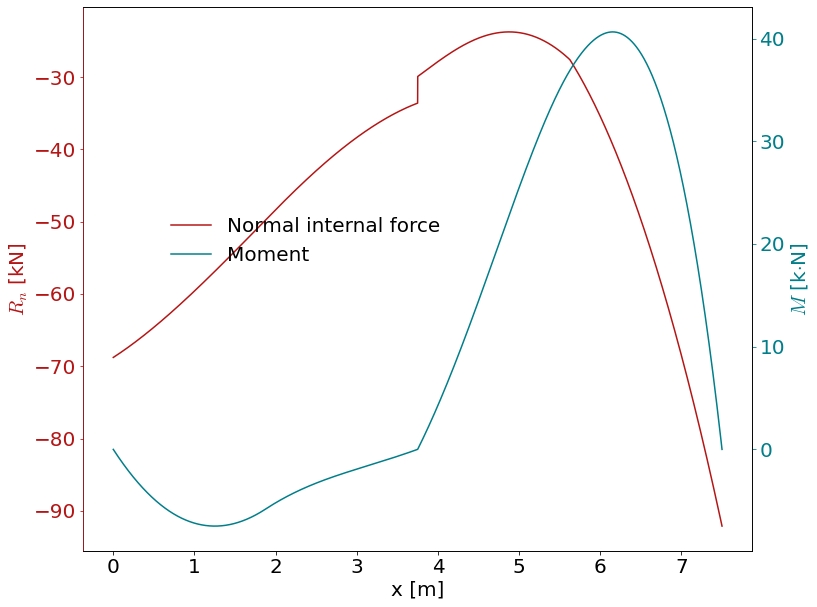

In [17]:
plt.figure()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.plot(x,moment,label="Moment",color=color_moment)
ax1.plot(x,Rn,label="Normal internal force",color=color_loads)

ax2.set_ylabel(r"$M$ [k$\cdot$N]", color=color_moment)
ax2.tick_params(axis='y', colors=color_moment)
ax2.spines["left"].set_color(color_moment)
ax1.set_ylabel(r'$R_n$ [kN]',color=color_loads)
ax1.tick_params(axis='y', colors=color_loads)
ax2.spines["left"].set_color(color_loads)

ax1.set_xlabel("x [m]")

fig.legend(loc=(0.2,0.55),framealpha=0.0)

plt.savefig("moment_normal.png",transparent=True)

plt.show()

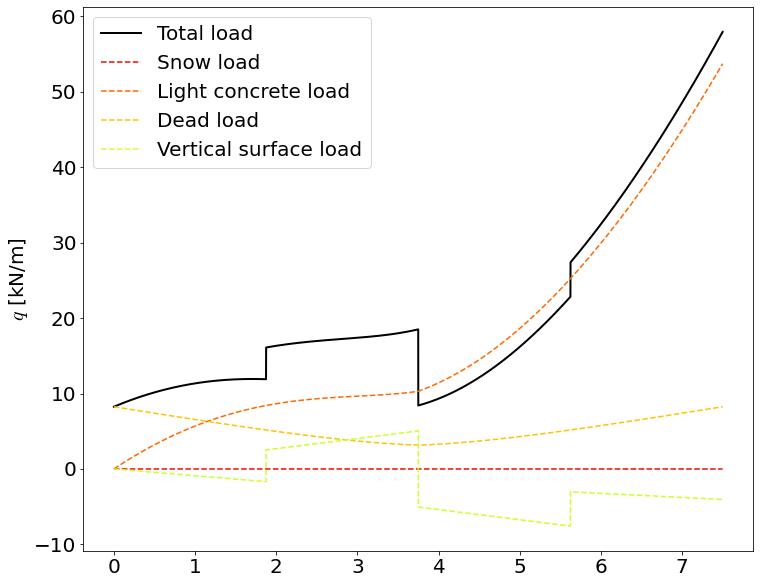

In [18]:
plt.figure()
plt.plot(x,load,color="k", label = "Total load",zorder=0,linewidth=2)
plt.plot(x,vert_load(x,0,L),"--",label = "Snow load")
plt.plot(x,light_concrete_load(derivative),"--",label = "Light concrete load")
plt.plot(x,dead_load(derivative,density,thickness,width),"--", label = "Dead load")
plt.plot(x,surface_load(x,normal_vector(x,tangent(x)),wind_pressure)[1],"--",label="Vertical surface load")
plt.ylabel(r"$q$ [kN/m]")
plt.legend()
plt.show()

In [19]:
print("LCX ", "M_max", "              N(M_max)", "          N_max")
print()
### LC1 ###
q1 = 0.8*0*KFI
wind_pressure = 1.0*0*KFI
density = 23.5*1.2*KFI
light_concrete_density = 12*1.2*KFI
solve()
print("LC1 ", maxmoment, maxRn, MaxRn)
LC["LC1"] = (moment, Rn,':')
### LC2 ###
print()
q1 = 0.8*1.5*KFI # kN/m^2 snow
wind_pressure = 1.0*0*KFI
density = 23.5*KFI
light_concrete_density = 12*KFI
solve([solution.x[0],solution.x[1]])
print("LC2 ",maxmoment, maxRn, MaxRn)
LC["LC2"] = (moment, Rn,"--")
### LC3 ###
print()
q1 = 0.8*0.0*KFI # kN/m^2 snow
wind_pressure = 1.0*1.5*KFI
density = 23.5*KFI
light_concrete_density = 12*KFI
solve()
print("LC3 ", maxmoment, maxRn, MaxRn)
LC["LC3"] = (moment, Rn,"-")
###########

LCX  M_max               N(M_max)           N_max

LC1  34.95108433980173 -60.32336495004647 -136.98533758786184

LC2  32.987959960545496 -58.83068282218445 -131.52804987194003

LC3  40.6502253930647 -39.30790173461464 -92.11376338968486


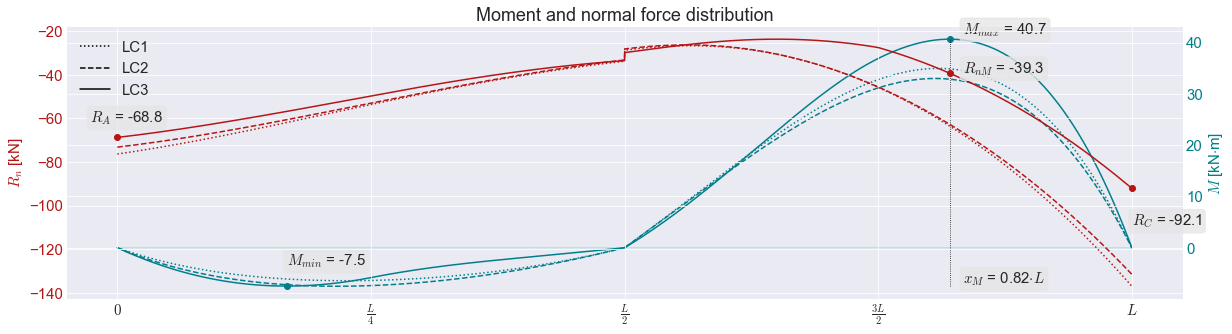

In [20]:
plt.style.use("seaborn-darkgrid")
plt.rcParams["font.size"]=15
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

ax1.plot(x,LC["LC1"][1],LC["LC1"][2], label = "LC1",color=color_loads)
ax1.plot(x,LC["LC2"][1],LC["LC2"][2], label = "LC2",color=color_loads)
ax1.plot(x,LC["LC3"][1],LC["LC3"][2], label = "LC3",color=color_loads)
ax2.plot(x,LC["LC1"][0],LC["LC1"][2],color=color_moment)
ax2.plot(x,LC["LC2"][0],LC["LC2"][2],color=color_moment)
ax2.plot(x,LC["LC3"][0],LC["LC3"][2],color=color_moment)
ax2.plot([0,L],[0,0],color=color_moment,alpha=0.2)

ax2.set_ylabel(r"$M$ [kN$\cdot$m]", color=color_moment)
ax2.tick_params(axis='y', colors=color_moment)
ax1.set_ylabel(r'$R_n$ [kN]',color=color_loads)
ax1.tick_params(axis='y', colors=color_loads)
#ax1.set_xlabel("x [m]")
ax1.legend(loc="upper left")
leg = ax1.get_legend()
leg.legendHandles[0].set_color("k")
leg.legendHandles[1].set_color("k")
leg.legendHandles[2].set_color("k")
props = dict(boxstyle='round', facecolor='#E6E6E6', alpha=0.8, pad=0.2,ec='#E6E6E6')

i = np.argmax([np.max(LC[f"LC{i+1}"][0]) for i in range(len(LC))])+1

R_a = LC[f"LC{i}"][1][0]
ax1.text(0-0.2,R_a+7,r"$R_A$ = "+f"{round(R_a,1)}",bbox=props)
R_c = LC[f"LC{i}"][1][-1]
ax1.text(L,R_c-17,r"$R_C$ = "+f"{round(R_c,1)}",bbox=props)
R_max_i = np.argmin(LC[f"LC{i}"][1])
R_max = LC[f"LC{i}"][1][R_max_i]
if R_max_i!=0 and R_max_i!=l-1:
    ax1.text(x[R_max_i],R_max,r"$R_{max}$ = "+f"{round(R_max,1)}",bbox=props)

M_max_i = np.argmax(LC[f"LC{i}"][0])
M_max = LC[f"LC{i}"][0][M_max_i]
ax2.text(x[M_max_i]+0.1,M_max+1,r"$M_{max}$ = "+f"{round(M_max,1)}",bbox=props)

M_min_i = np.argmin(LC[f"LC{i}"][0])
M_min = LC[f"LC{i}"][0][M_min_i]
ax2.text(x[M_min_i],M_min+4,r"$M_{min}$ = "+f"{round(M_min,1)}",bbox=props)

ax2.text(x[M_max_i]+0.1,M_min+0.5,r"$x_{M}$ = "+f"{round(x[M_max_i]/L,2)}"+r"$\cdot L$",bbox=props)

ax2.plot([x[M_max_i],x[M_max_i]],[M_min,M_max],":k",linewidth=0.8)
ax1.text(x[M_max_i]+0.1,Rn[M_max_i]+0.1,r"$R_{nM}$ = "+f"{round(Rn[M_max_i],1)}",bbox=props)

ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.scatter(x[0],Rn[0],color=color_loads)
ax1.scatter(x[-1],Rn[-1],color=color_loads)
ax2.patch.set_visible(True)
ax1.scatter(x[M_max_i],Rn[M_max_i],color=color_loads)
ax2.scatter(x[M_max_i],M_max,color=color_moment)
ax2.scatter(x[M_min_i],M_min,color=color_moment)

plt.xticks([0,L/4,Lhinge,3*L/4,L],[r"$0$",r"$\frac{L}{4}$",r"$\frac{L}{2}$",r"$\frac{3 L}{2}$",r"$L$"])

plt.title("Moment and normal force distribution")
plt.savefig("moment_normal_transparent.png",transparent=True,bbox_inches="tight",dpi=500)
plt.savefig("moment_normal.png",bbox_inches="tight",dpi=500)
plt.show()
plt.rcParams["font.size"]=20